<a id="0"></a> <br>
# 0. Environment

In [1]:
import pandas as pd
import numpy as np
! pip install tsfresh
from tsfresh.feature_extraction import extract_features
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import gc
import time
import warnings
# import tsfresh
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from itertools import product
gc.enable()
warnings.simplefilter("ignore")

     |████████████████████████████████| 9.8 MB 1.7 MB/s            
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
TARGET = 'activity'

<a id="1"></a> <br>
# 1. Data cleaning
## 1.1 Overview
Check all the raw signals given.

In [3]:
def read_csv(f_name):
    df = pd.read_csv('../input/har-dataset/'+f_name,index_col=[0],header=None).reset_index(drop=True);
    df.columns = ['x','y','z','activity']
    return df

In [4]:
import os
print(os.listdir('../input/har-dataset/'))

['1.csv', '11.csv', '3.csv', '5.csv', '2.csv', '13.csv', '14.csv', '4.csv', '8.csv', '12.csv', '9.csv', '7.csv', '15.csv', '6.csv', '10.csv']


In [5]:
file_list = [str(i+1)+'.csv' for i in range(15)]
raw_data = [read_csv(f_name) for f_name in file_list]

In [6]:
def plot_acc(df,title=None,ylim=(1000,3000)):
    t = df.index/52
    plt.figure(figsize=(18,3))
    plt.plot(t, df[['x','y','z']]);
    if ylim:
        plt.ylim(ylim)
    changes_i = np.insert(np.argwhere(df.activity.values[:-1] - df.activity.values[1:]).reshape(-1), 0, 0)
    changes = changes_i/52
    changes_c =[df.activity.iloc[i+1] for i in changes_i]
    text_p = 0.1*plt.gca().get_ylim()[1]+0.9*plt.gca().get_ylim()[0]
    for i,i_t in enumerate(changes[:-1]):
        plt.axvline(x=i_t,color='r',ls='--')
        plt.text(x=(i_t+changes[i+1])/2, y=text_p, s=str(changes_c[i]),
                 horizontalalignment='center',color='k',fontsize=20)
    plt.axvline(x=max(t),color='r',ls='--')
    if title:
        plt.title(title,fontsize = 20);
    plt.show()

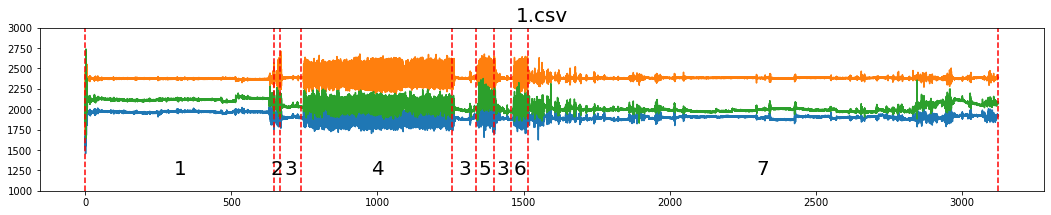

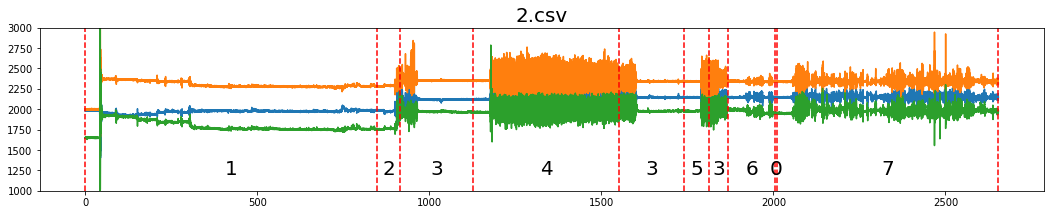

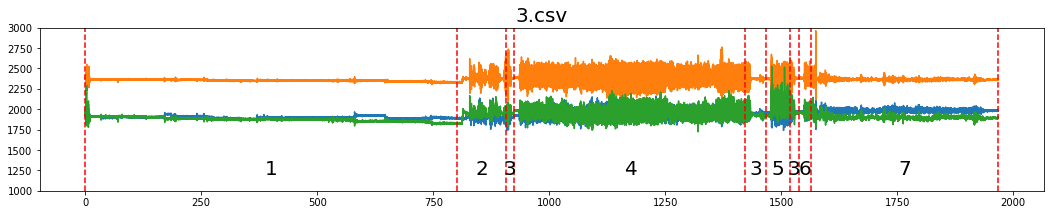

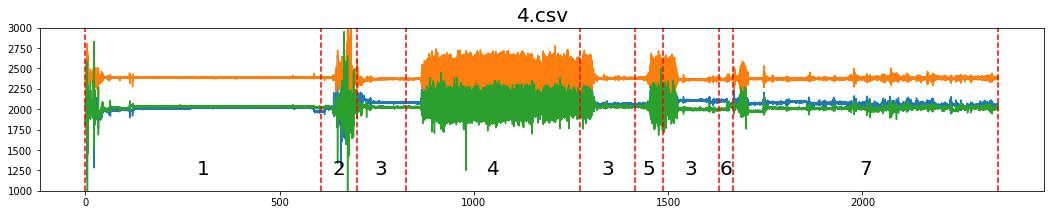

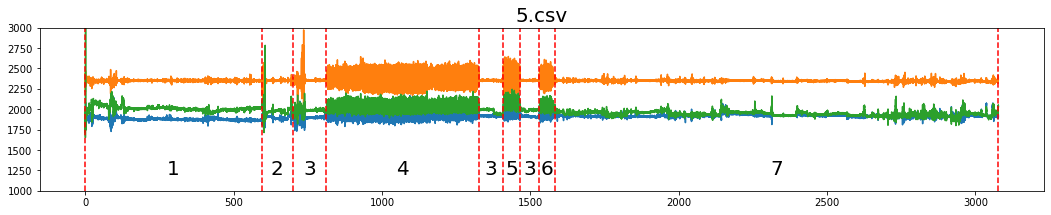

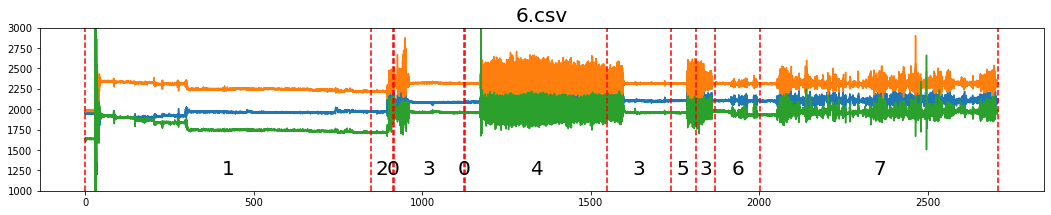

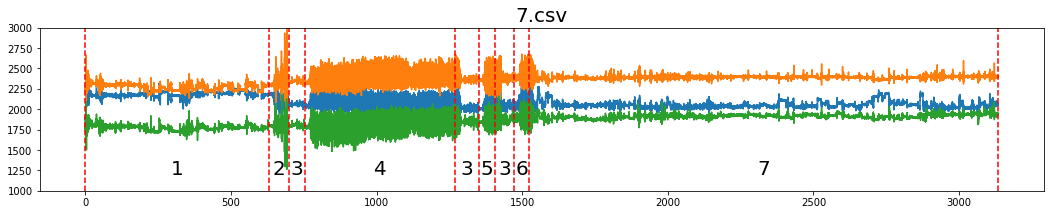

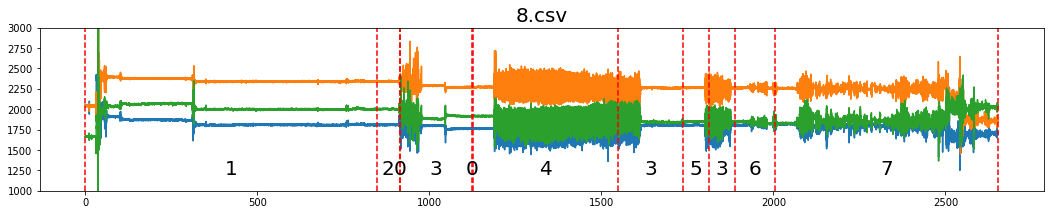

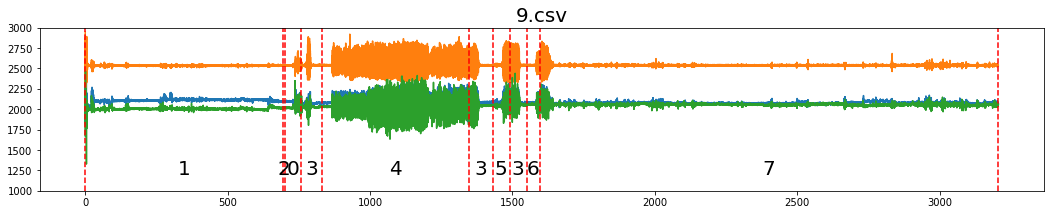

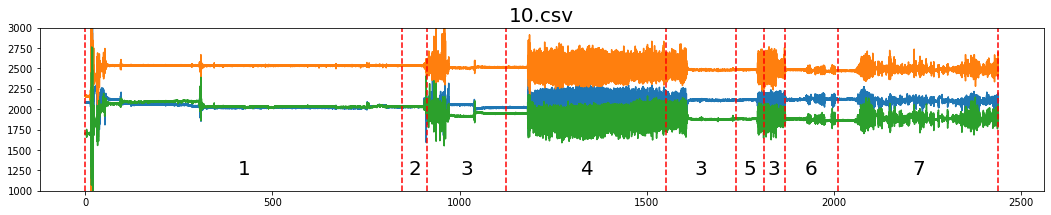

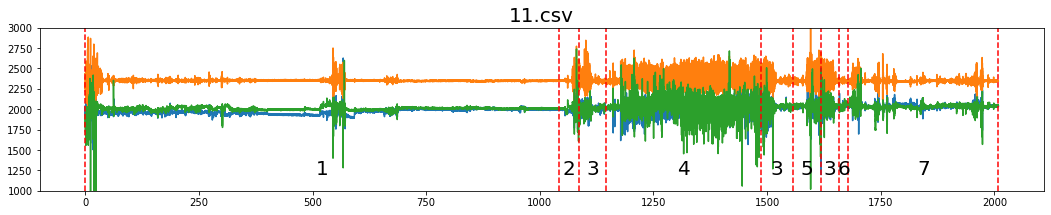

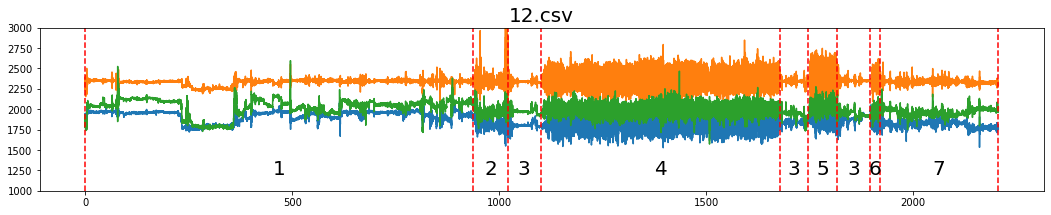

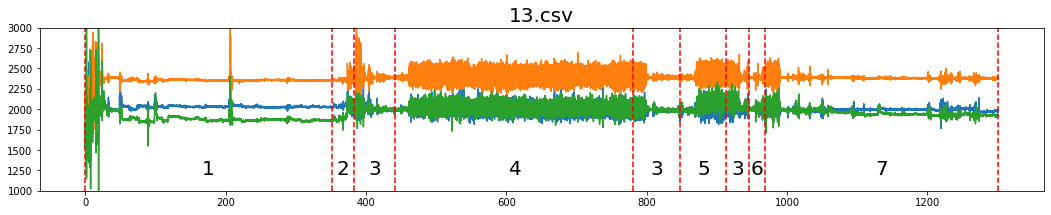

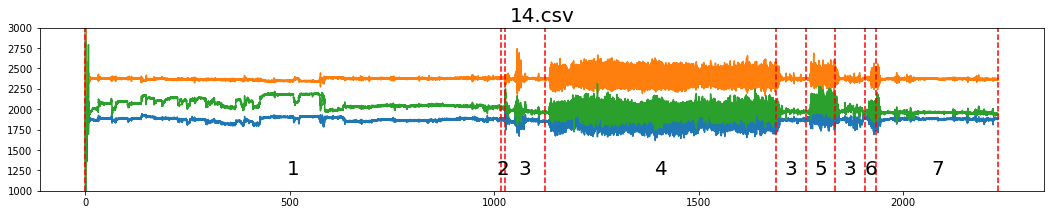

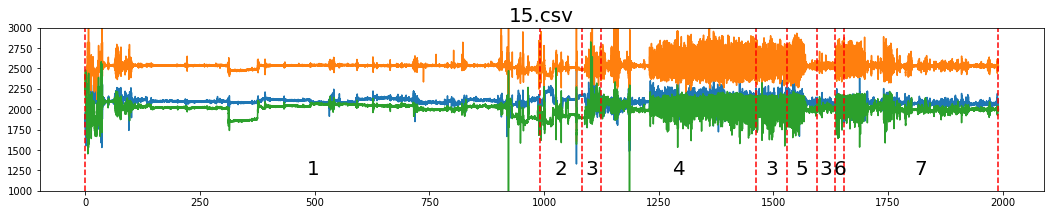

In [7]:
# lets check how these acceleration history looks like
for df,f_name in zip(raw_data,file_list):
    plot_acc(df,f_name)

Blue, green and orange lines are corresponding to the x,y,z acceleration histories. The red dash line indicates the transition between different activities (encoded number shown on graph). Here come some observations.
1. There are only a few data missing (the sequence number is slightly larger than the value counts, and some data has a label 0). Considering the fact that there are quite sufficient data (a signal file contents over 100k rows), the missing data are dropped and ignored. (This is safe as acceleration is a transient quantity, physically speaking)
2. The acceleration data is not calibrated (have an offset and the unit is unknown).
3. There is a very large spike in all the data at the very beginning, maybe is due to the setup of the device. I manually cut off the spike at begining.
4.  '5.csv' shows very intuitive labels. When the person moves, there is an immediate response on the acceleration reading. Labels in other files are not very intuitive. The activity transitions (labels) seem to have a delay, compared with the change in acceleration readings. This could be a mistake in the label or preprocessing part, I manually shifted the labels for each file.

In [8]:
# double check the miss alignment
# for c,df in raw_data[2].groupby('activity'):
#     plt.plot(df.x)#, color = c_map[c])

## 1.2 Manually align the data and remove the starting parts

In [9]:
cut_dict = { '1.csv':[400,400],
             '2.csv':[2600,20000],
             '3.csv':[650,2000],
             '4.csv':[1900,10000],
             '5.csv':[0,200],
             '6.csv':[2500,20000],
             '7.csv':[1000,3000],
             '8.csv':[3200,20000],
             '9.csv':[1800,3000],
             '10.csv':[3000,20000],
             '11.csv':[1500,2000],
             '12.csv':[550,3000],
             '13.csv':[1000,2000],
             '14.csv':[600,2000],
             '15.csv':[5500,10000]}

In [10]:
def align_and_cut(df_in,align = 0, cut= 0):
    df = df_in.copy()
    df.activity = np.pad(df.activity[:len(df)-align],(align,0),mode ='edge')
    df = df[cut:]
    df = df[df.activity!=0].reset_index(drop=True)
    df.iloc[len(df)-1,3]=0 #flag at the end
    return df

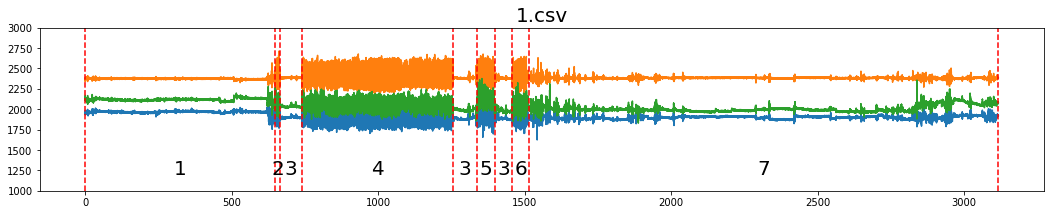

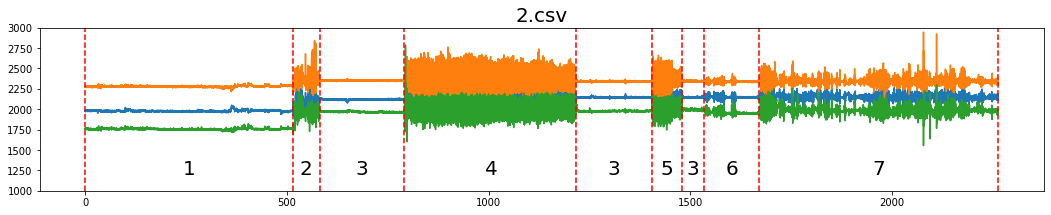

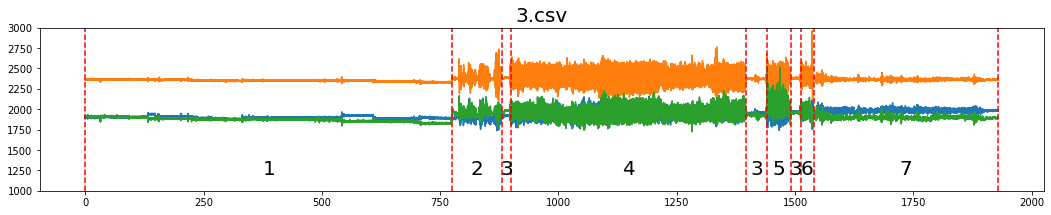

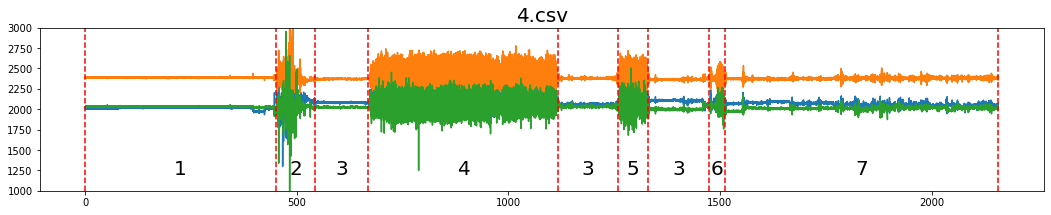

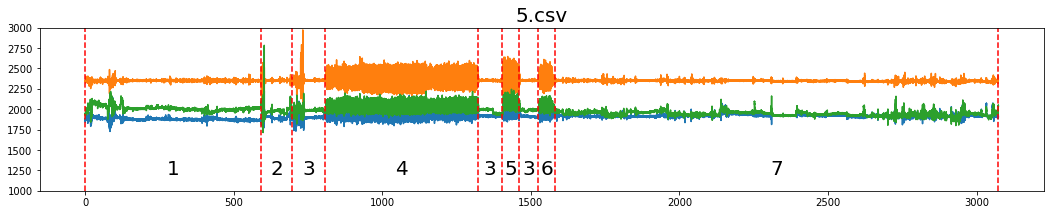

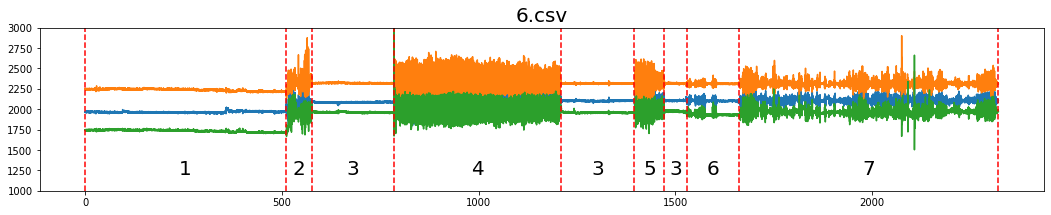

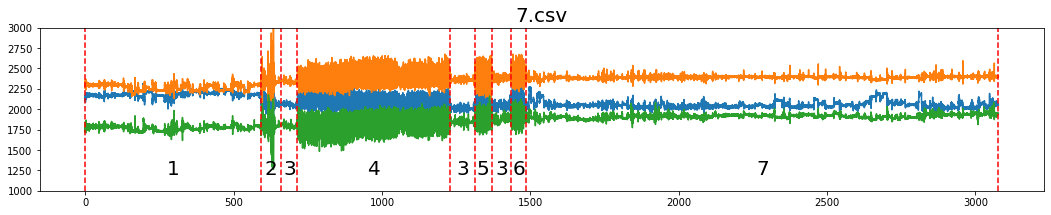

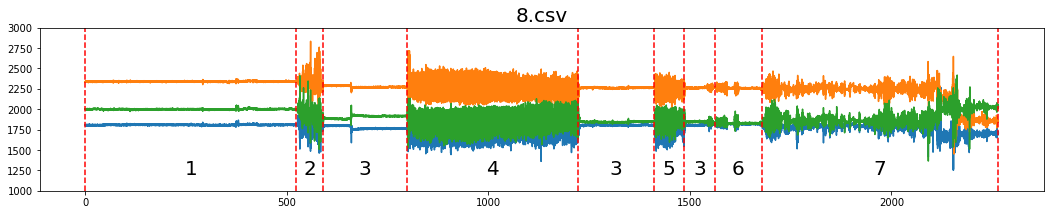

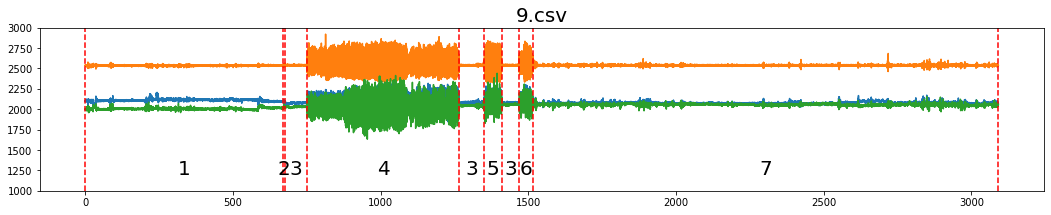

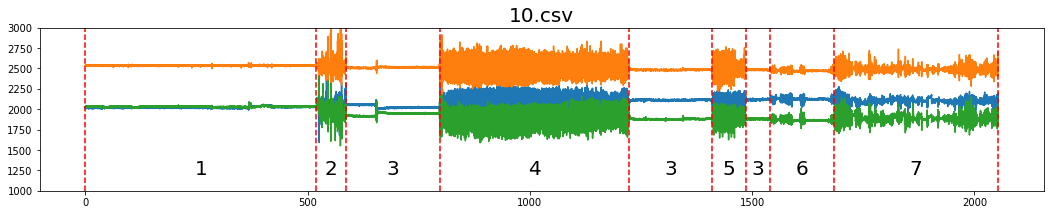

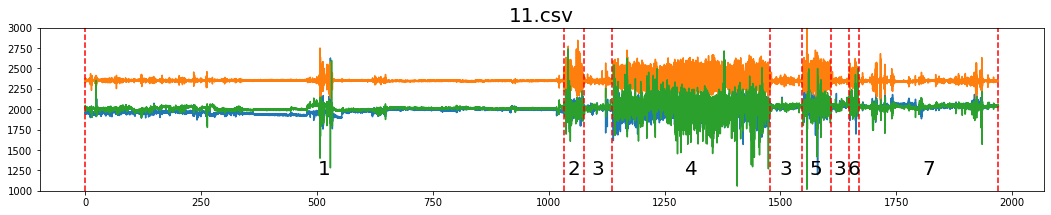

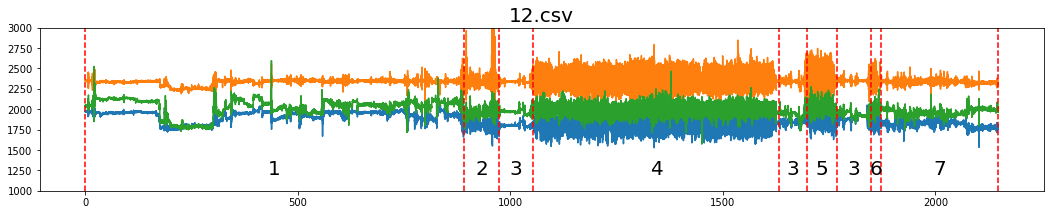

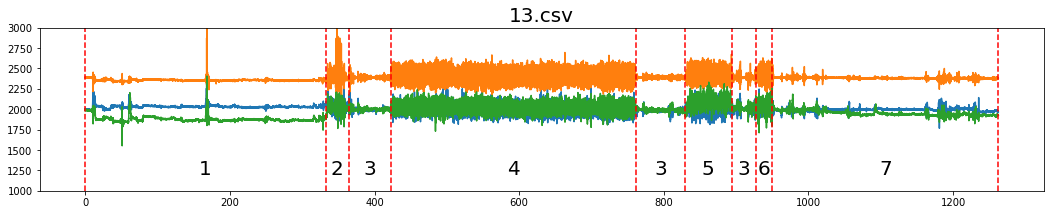

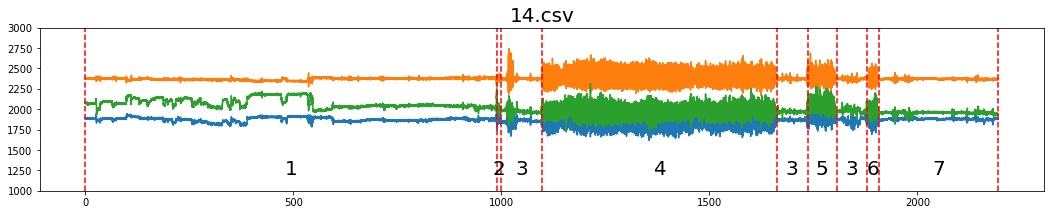

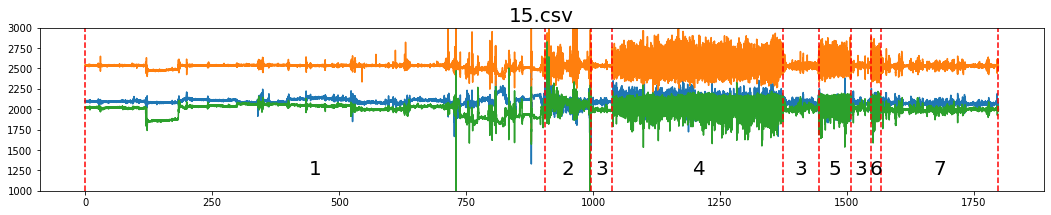

In [11]:
process_data = {}
for df,f_name in zip(raw_data,file_list):
    ndf = align_and_cut(df,cut_dict[f_name][0],cut_dict[f_name][1])
    process_data[f_name] = ndf
    plot_acc(ndf,f_name)

## 1.3 Accelerometer calibration
Here I profermed a navie calibration for the accelerometer. By assuming the offset simply equals to the mean measuring when the person is working on the computer (case 1). Each test (indiviual) have there own offset. In addition, the moving directions seems to be not important in this task (walk left or right, going up and down), and I also don't know the positve/negtive directions about the recording. So after subtracting the mean value, It the mean of all observation value is negtive, I reverse the sign for all the data to make the overall mean a positive number.

In [12]:
mean = {fn:df[df.activity==1][['x','y','z']].mean()for fn, df in process_data.items()}
mean = pd.DataFrame(mean)
mean

,1.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv,10.csv,11.csv,12.csv,13.csv,14.csv,15.csv
x,1965.044095,1980.518093,1899.502195,2014.473976,1878.346264,1966.504220,2185.253333,1808.599670,2111.101433,2022.878780,1971.235551,1917.493715,2031.758681,1874.443963,2101.860085
y,2374.404490,2280.200710,2352.427452,2385.945819,2351.193827,2237.578259,2271.772195,2340.038767,2535.781456,2535.203327,2351.712130,2332.595119,2357.051505,2370.282642,2526.074968
z,2119.216201,1757.091664,1872.704327,2031.211732,2010.987622,1734.994084,1773.289984,2000.692915,2006.734709,2031.624510,2007.749562,2025.230821,1879.741840,2075.476464,1997.950998


In [13]:
# for f_name, df in process_data.items():
#     df.x = df.x - mean.mean().x
#     df.y = df.y - mean.mean().y
#     df.z = df.z - mean.mean().z

In [14]:
for f_name, df in process_data.items():
    df.x = df.x - mean.loc['x',f_name]
    df.y = df.y - mean.loc['y',f_name]
    df.z = df.z - mean.loc['z',f_name]

In [15]:
for _, df in process_data.items():
    if df.x.mean()<0: df.x = -df.x
    if df.y.mean()<0: df.y = -df.y
    if df.z.mean()<0: df.z = -df.z

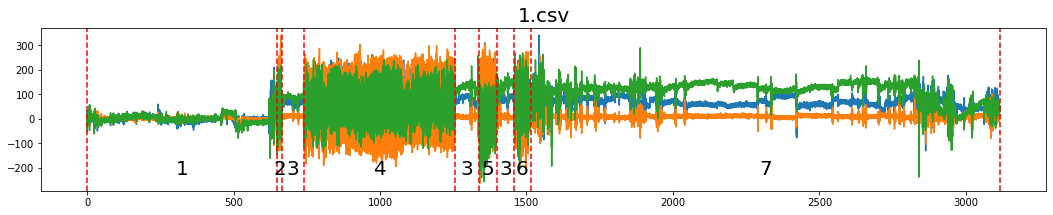

In [16]:
# the reading after calibriation
plot_acc(process_data['1.csv'],'1.csv',ylim=None)

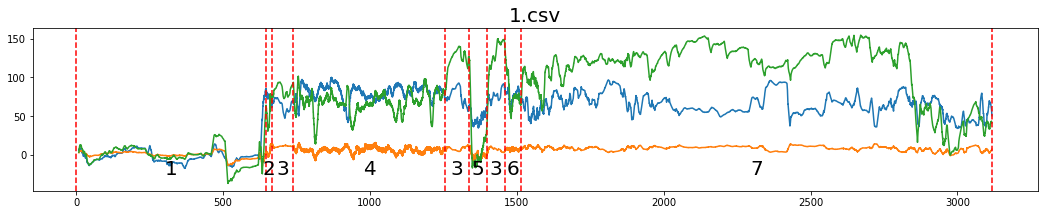

In [17]:
# the moving average with a 500 moving window
plot_acc(pd.concat([process_data['1.csv'][['x','y','z']].rolling(500).mean(),process_data['1.csv'].activity],axis=1),'1.csv',ylim=None)

It's clear that mean value, stander derivation and FFT features are very good features for this classification task.

In [18]:
for _, df in process_data.items():
    df.iloc[len(df)-1,3]=df.iloc[len(df)-2,3] #remove the flag at the end

In [19]:
pickle.dump(process_data, open('data.pickle','wb'))
del raw_data
gc.collect()

22391

<a id="2"></a> <br>
# 2. Exploratory data analysis
## 2.1. The target class distribution
From the previous section, one can tell the activity class is unbalanced, class 1 and 7 are the dominated class when class 2, 5 and 6 are under-represented. Let us check the overall class counts among 15 files.

In [20]:
process_data = pickle.load(open('data.pickle','rb'))

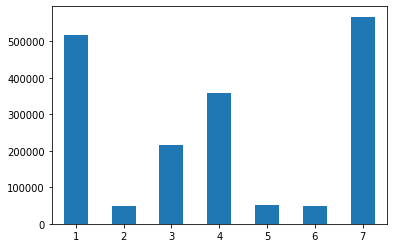

In [21]:
all_targets = pd.concat([df.activity.value_counts() for df in process_data.values()],axis=1).sum(axis=1)
all_targets.plot.bar(rot=0);

This is a large data set for the minority class there are more than 40,000 samples (they will have large overlap).

In [22]:
all_targets

1    517267
2     47878
3    216737
4    357064
5     51498
6     47770
7    567377
dtype: int64

In [23]:
assert sum([df.activity.nunique() for df in process_data.values()]) == 15*7
print('All the file contains all 7 classes')

All the file contains all 7 classes


## 2.2. Acceleration records per axis

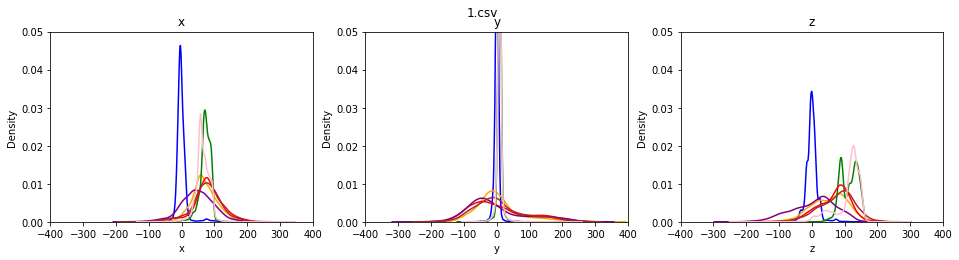

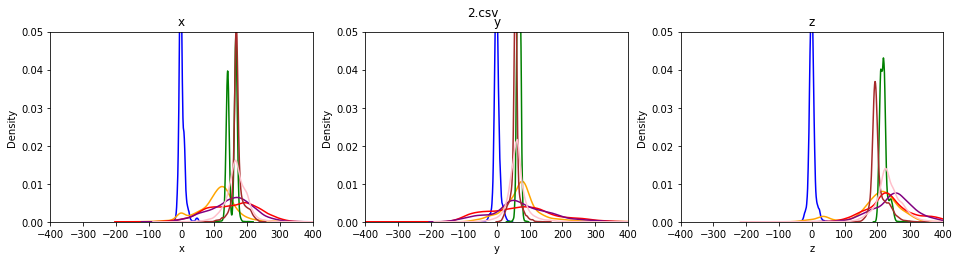

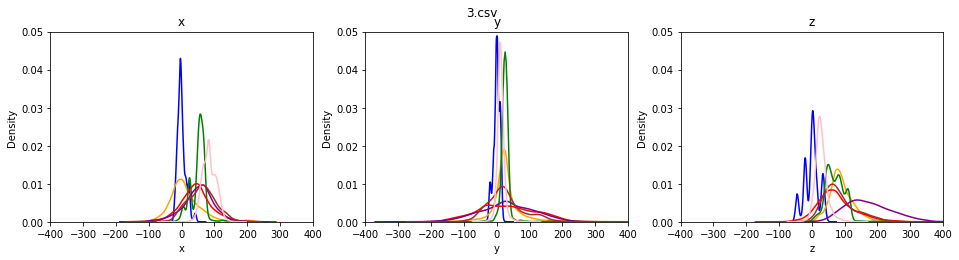

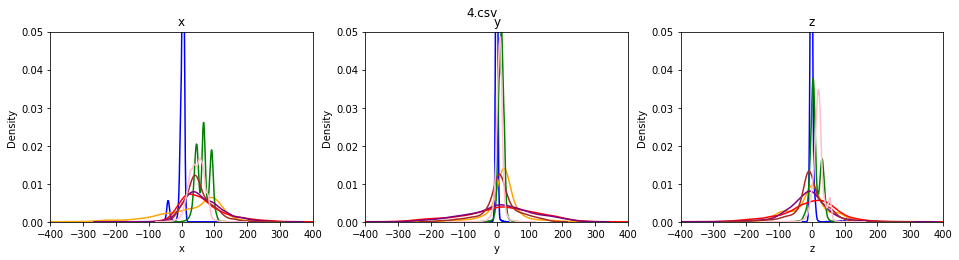

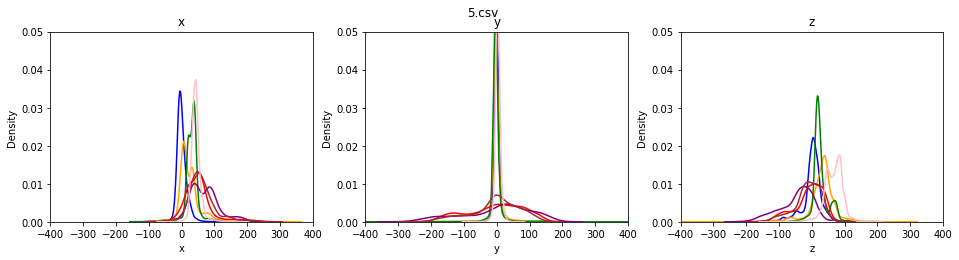

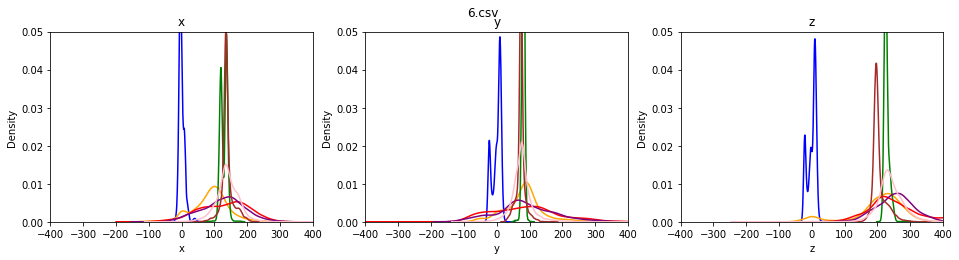

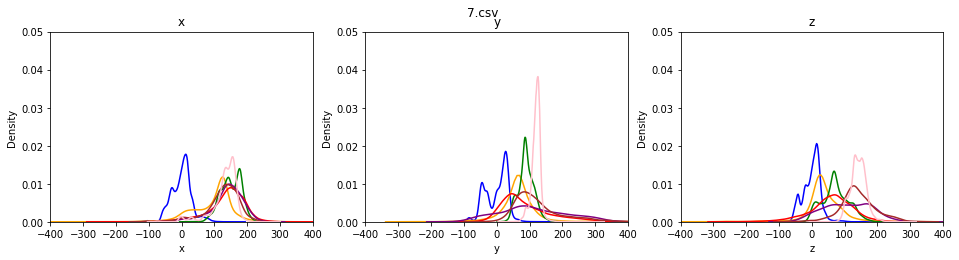

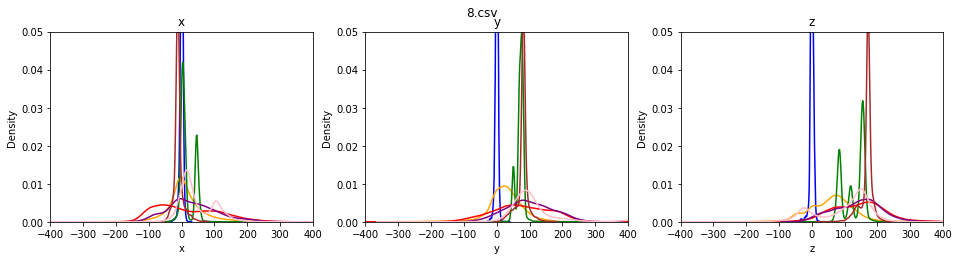

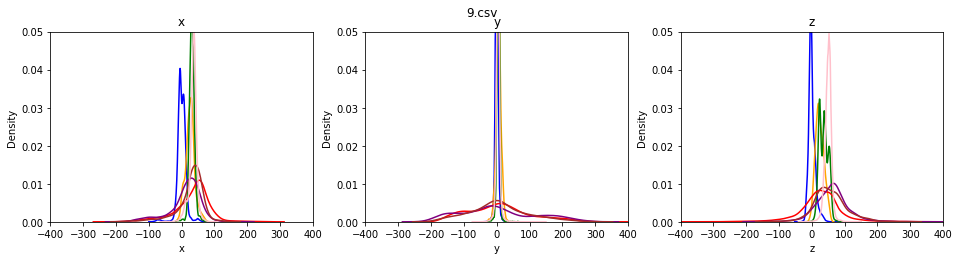

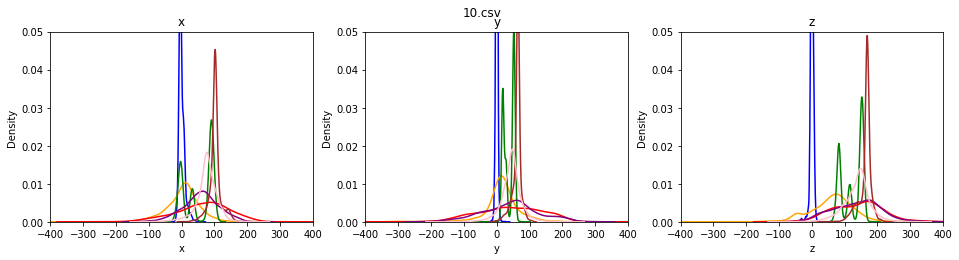

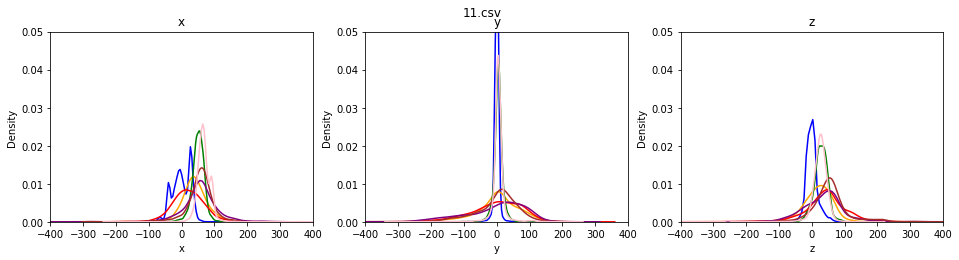

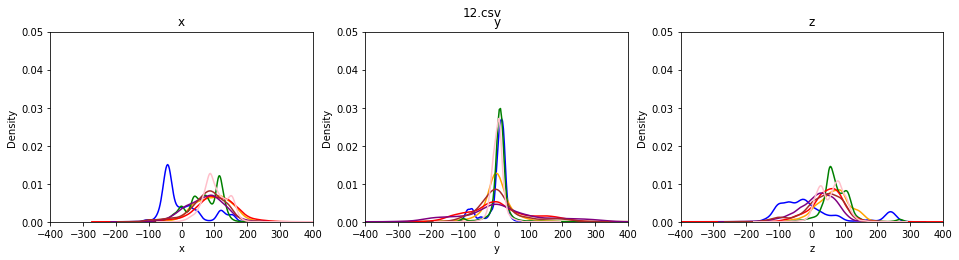

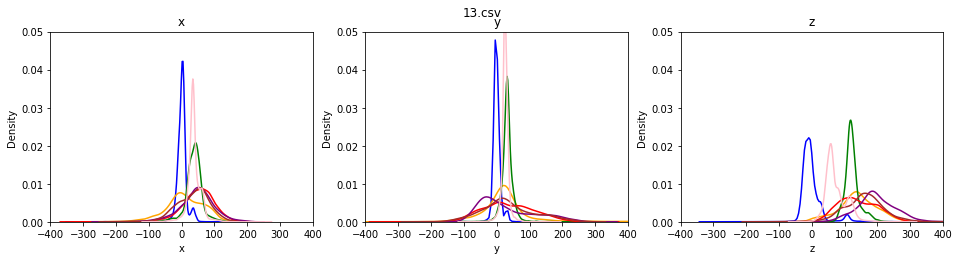

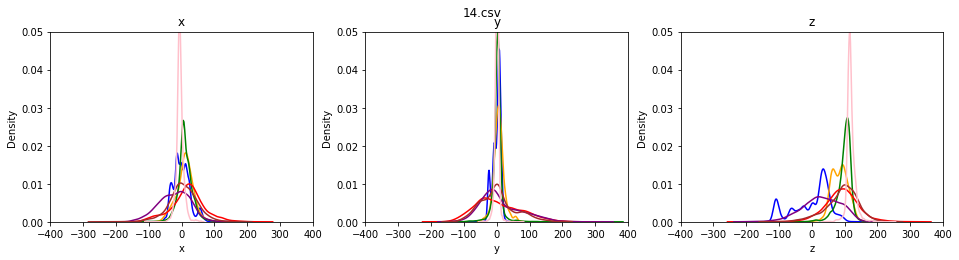

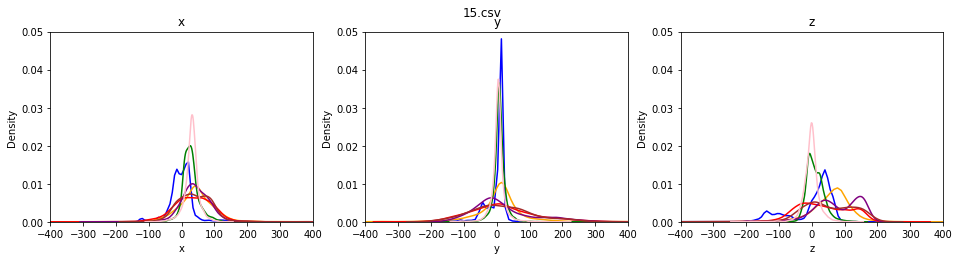

In [24]:
# check the kernal density estimation for each indiviual file/person at each axis 
c_map = {1:'b',2:'orange',3:'green',4:'r',5:'purple',6:'brown',7:'pink'}
for f_name in file_list:
    df = process_data[f_name]
    plt.figure(figsize=[16, 3.5]);
    for c, df_ in df.groupby('activity'):
        for i, col in enumerate(['x','y','z']):
            plt.subplot(1, 3, i+1); sns.kdeplot(df_[col], legend= False, c = c_map[c]); 
            plt.xlim((-400,400));plt.ylim((0,0.05));plt.title(col)
    plt.suptitle(f_name);
    plt.show();

As I set class 1 (working at a computer) as the calibration case, the mean of all the observations of class 1 appears to be 0. For most of these individuals (file/person), the mean values of other classes (2-7) are very different from class 1, the standard derivation will also be an informative feature.

## 2.3. Time series analysis
### 2.3.1 Window size
The time window is the minimal length of a signal where used to extract features. I found some researches on this topic giving the following information: (1). Larger time window leads to a better result. (2) Currently, the best time window is found to be between1s~7s (a very wide range as the data and sample frequency are different) [Paper 1](#p1) [Paper 1](#p2). I take a tentative guess that time window should be smaller than 5s. I used several different time windows to compute time series features. In order to check the effects of the window size and determine the best window size.

In [25]:
# time windows used to compute time series features
windows = [25,50,100,200] # count of data point used

### 3.2.2 Feature extraction
Based on previous EDA and some insight from [Paper 3](#p3). The computed feature are planned as follow: Mean, standard deviation, skewness, kurtosis, average sum of the squares (energy), signal entropy, autocorrelation, linear trend, the correlation coefficient between acceleration histories and the maximum, mean, skewness, kurtosis of the frequency signal got from Fast Fourier Transform. I'm using a sliding window of 15 (data point, 15/52s) to sample the data from raw time series. 

In [26]:
def prepare_ts(df, window_size = 10, step_size=1):
    # lag is step between windows
    shifts = np.arange(window_size//step_size+int(window_size%step_size>0))*step_size
    return pd.concat([ts_valus(df, i, window_size) for i in shifts])

def ts_valus(df, shift, window_size):
    end_ = len(df) - shift
    start_ = end_ % window_size
    return df[start_ : end_]

In [27]:
def ts_features(df, features, cols=['x','y','z'],target='activity', window_size =10, step_size=1):
    df_pad = prepare_ts(df, window_size, step_size)
    df_pad['id'] = np.repeat(np.arange(len(df_pad)//window_size),window_size) # id used to seperate the time series
    new_target = df_pad[target][0::window_size]
    return extract_features(df_pad[cols+['id']], default_fc_parameters=features, column_id = 'id', 
                            n_jobs=8, disable_progressbar =True).join(new_target.reset_index(drop=False))

In [28]:
features = {'mean': None, 
            'standard_deviation': None, 
            'skewness':None,
            'kurtosis':None,
            'abs_energy': None,
            'sample_entropy':None, 
            'linear_trend':[{'attr':'slope'},
                            {'attr':'rvalue'}],
            'autocorrelation':[{'lag':8}],
            'fft_aggregated':[{'aggtype': 'centroid'},
                              {'aggtype': 'variance'},
                              {'aggtype': 'skew'},
                              {'aggtype': 'kurtosis'}]
           }

In [29]:
%%time
for w_s in windows:
    sub_feat = {}
    for f_name in file_list:
        sub_feat[f_name] = ts_features(process_data[f_name],features, window_size=w_s,step_size=15)
    pickle.dump(sub_feat, open('feature_'+str(w_s)+'.pickle','wb'))
    del sub_feat
    gc.collect()
#take 3 hours

CPU times: user 9min 57s, sys: 35.1 s, total: 10min 32s
Wall time: 1h 23min 49s


In [30]:
## Extra operations on the data merge and remove duplicates
def add_file_label(df, f_name):
    df['file'] = int(f_name.split('.')[0])
    df = df.drop_duplicates(subset=['index'], keep='first')
    return df

all_data = {}
for window in windows:
    temp_f = pickle.load(open('feature_'+str(window)+'.pickle','rb'))
    df = pd.concat([add_file_label(temp_f[f_name],f_name) for f_name in file_list], axis=0)
    df[['activity','index','file']]= df[['activity','index','file']].astype(int)
    all_data[window] = df

In [31]:
len(all_data[25].columns)

42

### 3.2.3 Check the generated features for small time window

In [32]:
# the time window is 30 data point, 30/52 s
f25_merge = all_data[25]
# total number of rows
len(f25_merge)

144429

In [33]:
def violin_and_distplot(df, cols):
    for col in cols:
        plt.figure(figsize=[20, 4])
        plt.subplot(1, 2, 1)
        sns.violinplot(x=TARGET, y=col, data=df);plt.grid();
        plt.subplot(1, 2, 2); sns.distplot(df[col].dropna()); plt.grid()
        plt.suptitle(col+' , missing '+ str(df[col].isna().sum()*100/len(df))[:5]+'% data')
        plt.show();

In [34]:
feature_names = list(f25_merge.columns)
feature_names.remove('index')
feature_names.remove('file')
feature_names.remove('activity')

In [35]:
# Looks like all the numbers are valid
f25_merge[feature_names].describe().T

,count,mean,std,min,25%,50%,75%,max
x__mean,144429.0,5.030492e+01,55.939289,-254.833976,5.046024,3.926143e+01,8.496410e+01,2.795001e+02
x__standard_deviation,144429.0,1.826391e+01,23.591255,1.304761,3.191489,5.367457e+00,2.609656e+01,2.494862e+02
x__skewness,144429.0,6.735309e-03,0.637630,-4.560251,-0.368705,2.541341e-04,3.774781e-01,4.752997e+00
x__kurtosis,144429.0,4.507648e-02,1.293341,-1.999047,-0.731491,-2.488973e-01,4.454925e-01,2.329188e+01
x__abs_energy,144429.0,1.637470e+05,217847.258121,63.455877,9874.678041,6.236174e+04,2.239390e+05,2.283989e+06
x__sample_entropy,133582.0,inf,NaN,0.154151,1.252763,inf,inf,inf
"x__linear_trend__attr_""slope""",144429.0,-1.546024e-03,1.987865,-22.716154,-0.235385,-7.692308e-04,2.238462e-01,1.626538e+01
"x__linear_trend__attr_""rvalue""",144429.0,3.676781e-03,0.408735,-0.994240,-0.279001,-1.022567e-03,2.818397e-01,9.859742e-01
x__autocorrelation__lag_8,144429.0,-1.404631e-01,0.271073,-1.034001,-0.316189,-1.244959e-01,4.515746e-02,8.925429e-01
"x__fft_aggregated__aggtype_""centroid""",144429.0,1.893570e+00,1.340284,0.104071,0.815833,1.565006e+00,2.706932e+00,7.832848e+00


In [36]:
del f25_merge
gc.collect()

21

# 4. Model
## 4.1 Overall training plan
1. Leave out split over files. As my data is sampled with a relatively small step (15 data point). So the features I should expect that the training data sampled from a single file have some level of self-correlation. So the data should be split by their source (CSV file, labeled use 'file' in the dataframe). I will use data from 3.csv, 4.csv, 10.csv, and 11.csv as the test set. Then do a 5-fold cross-validation on the remaining 11 files (by binding 13.csv and 15.csv, the data in each fold will be roughly the same).
2. Imbalanced classes. The training sample will be weighted differently (inversely proportional to their population) to enhance the underrepresent. A weighted metric (log-loss, F1 score) is used to evaluate the results. As well as the confusion matrix, a powerful tool to check out the performance of multiclass classification problem. 

In [37]:
test_set = {w_s:df[df.file.isin([12,13,14,15])] for w_s, df in all_data.items()}

In [38]:
# 5 groups by the roughly same among data.
# folds = [(1,10), (9,14), (2,7), (5,8), (6,13,15)]
folds = [(1,2,3,4,5,6,7,8,9,10,11)]

In [39]:
def get_fold_data(w_s,fold):
    df = all_data[w_s]
    dev_x = df[~df.file.isin(folds[fold])][feature_names]
    dev_y = df[~df.file.isin(folds[fold])][TARGET]
    val_x = df[df.file.isin(folds[fold])][feature_names]
    val_y = df[df.file.isin(folds[fold])][TARGET]
    return dev_x, dev_y, val_x, val_y

In [40]:
class_weights = all_targets.sum()/all_targets/7
classes = class_weights.index.values

## 4.2 Gradient boosting
Here I use the LightGBM (gradient boosting) as a quick starting point. The tree-based gradient boosting works friendly with outliers (don't need further opperations now). The results are easy to interpret.

In [41]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_log_ones = np.sum(y_ohe.values * np.log(y_p), axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def lgbm_multi_weighted_logloss(y_true, y_preds):
    loss = multi_weighted_logloss(y_true, y_preds, classes, class_weights)
    return 'wloss', loss, False

In [42]:
def plot_confusion_matrix(y, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def get_class_prediction(x ,clf):
    oof_preds = clf.predict_proba(x, num_iteration=clf.best_iteration_)
    return np.argmax(oof_preds,axis=-1)+1

In [43]:
import re

In [44]:
def lgbm_cross_validation(params, w_s, nr_fold=1, random_state=1):
    f_imp = np.zeros(len(feature_names))
    train_s=[]
    valid_s =[]
    clfs =[]
    for fold_ in range(nr_fold):
        dev_x, dev_y,val_x,val_y = get_fold_data(w_s,fold_)
        dev_x = dev_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        val_x = val_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        clf = LGBMClassifier(**params)
        clf.fit(
            dev_x, dev_y,
            eval_set=[(dev_x, dev_y), (val_x, val_y)],
            eval_metric=lgbm_multi_weighted_logloss,
            verbose=-1,
            early_stopping_rounds=15,
            sample_weight = dev_y.map(class_weights)
        )
        clfs.append(clf)
        # pred
        f_imp += np.array(clf.feature_importances_)
        # learning curve
        train_m = clf.evals_result_['training']['wloss']
        valid_m = clf.evals_result_['valid_1']['wloss']
        train_s.append(clf.evals_result_['training']['wloss'][-1])
        valid_s.append(clf.evals_result_['valid_1']['wloss'][-1])
        plt.plot(range(len(train_m)),train_m,'b')
        plt.plot(range(len(train_m)),valid_m,'r')
    plt.show()
    print('Window size',w_s)
    print('Train score',np.mean(train_s),np.std(train_s),'Valid score',np.mean(valid_s),np.std(valid_s))
    f_imp= f_imp/nr_fold
    return clfs, np.mean(valid_s), f_imp

In [45]:
paras = {'max_depth':4,
         'learning_rate':0.05,
         'num_leaves':8,
         'reg_alpha':1,
         'reg_lambda':1,
         'colsample_bytree':0.5,
         'random_state':18,
         'subsample' :0.5,
         'n_estimators':2000
        }

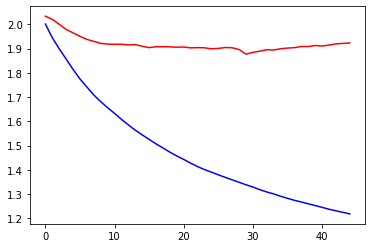

Window size 25
Train score 1.2183484205177801 0.0 Valid score 1.9229858691906316 0.0


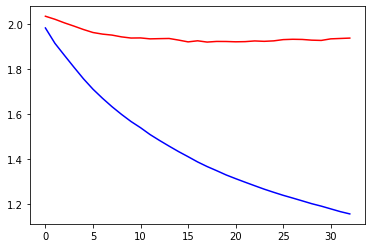

Window size 50
Train score 1.155561899632716 0.0 Valid score 1.9384510419362158 0.0


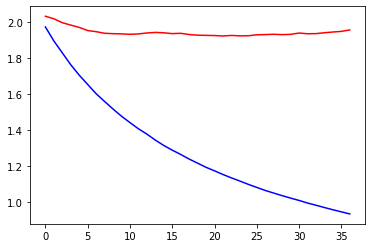

Window size 100
Train score 0.9317418330916648 0.0 Valid score 1.9569586218080464 0.0


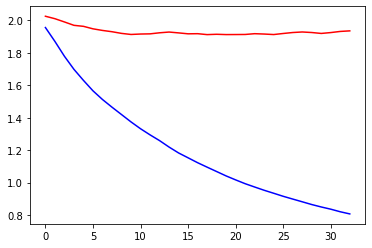

Window size 200
Train score 0.8069097640811074 0.0 Valid score 1.9352867657273416 0.0


In [46]:
clfs_dict, score_dict, f_imp_dict ={},{},{}
for w_s in windows:
    clfs_dict[w_s], score_dict[w_s], f_imp_dict[w_s] = lgbm_cross_validation(paras,w_s)

In [47]:
pickle.dump(clfs_dict,open('models.pickle','wb'))

In [48]:
def make_preditions(clfs,test_x):
    oof_preds = np.zeros((len(test_x), 7))
    for clf in clfs:
        oof_preds += clf.predict_proba(test_x, num_iteration=clf.best_iteration_)
    return np.argmax(oof_preds/len(clfs),axis=-1)+1

In [49]:
y_preds,f1_scores = {},[]
for w_s in windows:
    y = make_preditions(clfs_dict[w_s],test_set[w_s][feature_names])
    y_preds[w_s]=y
    f1_s = f1_score(test_set[w_s][TARGET],y,average='weighted')
    f1_scores.append(f1_s)
    print('Window size',w_s,'Accuracy:', accuracy_score(test_set[w_s][TARGET],y),'F1 score', f1_s)

Window size 25 Accuracy: 0.7712392829306314 F1 score 0.7769693235040259
Window size 50 Accuracy: 0.7845309251559252 F1 score 0.7852762761850862
Window size 100 Accuracy: 0.82534729960627 F1 score 0.8298998797063045
Window size 200 Accuracy: 0.8416198728199026 F1 score 0.8438684222019949


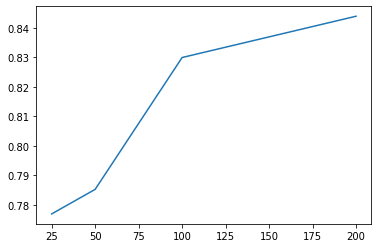

In [50]:
plt.plot(windows,f1_scores);

For the current features I have the large the time window, the better of the performance. Let's look a little bit more on the time window of 260.

Normalized confusion matrix


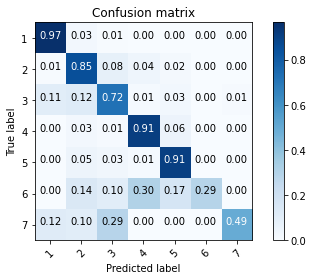

In [51]:
plot_confusion_matrix(test_set[200][TARGET], y_preds[200], classes,normalize=True)

The model performance is not very good (especially on class7), but the performance is relatively even on each classes. Class 3 and 7 seems to be hard to sperated.

In [52]:
sorted(zip(f_imp_dict[200],feature_names),reverse=True)

[(97.0, 'z__mean'),
 (68.0, 'x__mean'),
 (67.0, 'y__standard_deviation'),
 (56.0, 'y__mean'),
 (49.0, 'z__abs_energy'),
 (48.0, 'x__standard_deviation'),
 (47.0, 'x__abs_energy'),
 (44.0, 'y__abs_energy'),
 (31.0, 'z__standard_deviation'),
 (29.0, 'z__autocorrelation__lag_8'),
 (25.0, 'y__kurtosis'),
 (25.0, 'y__fft_aggregated__aggtype_"kurtosis"'),
 (25.0, 'y__fft_aggregated__aggtype_"centroid"'),
 (24.0, 'x__autocorrelation__lag_8'),
 (21.0, 'z__sample_entropy'),
 (21.0, 'x__fft_aggregated__aggtype_"centroid"'),
 (18.0, 'y__skewness'),
 (18.0, 'x__fft_aggregated__aggtype_"kurtosis"'),
 (17.0, 'y__autocorrelation__lag_8'),
 (16.0, 'z__skewness'),
 (16.0, 'y__fft_aggregated__aggtype_"skew"'),
 (16.0, 'x__fft_aggregated__aggtype_"skew"'),
 (14.0, 'x__fft_aggregated__aggtype_"variance"'),
 (13.0, 'z__fft_aggregated__aggtype_"skew"'),
 (12.0, 'x__sample_entropy'),
 (11.0, 'y__sample_entropy'),
 (10.0, 'z__fft_aggregated__aggtype_"centroid"'),
 (10.0, 'y__fft_aggregated__aggtype_"variance"